In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import healpy as hp

import matplotlib.pylab as pl

# Load some spherical data 

The data consists of ...

The produced maps have been down-sampled from `NSIDE=1024` to `NSIDE=64` using the `ud_grade` function of the `healpy` package.

In [3]:
data = np.load('data/maps_downsampled_64.npz')
assert(len(data['class1'])==len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to see a difference by eye.

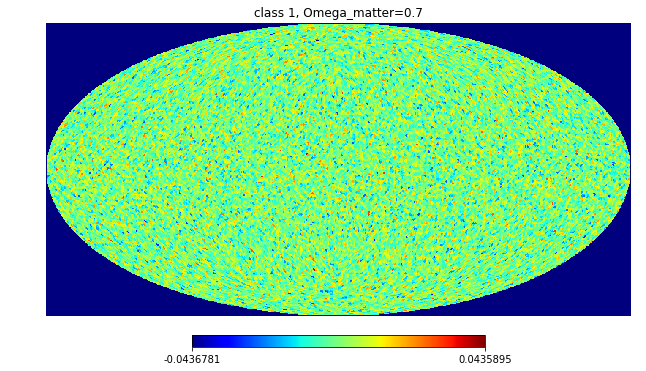

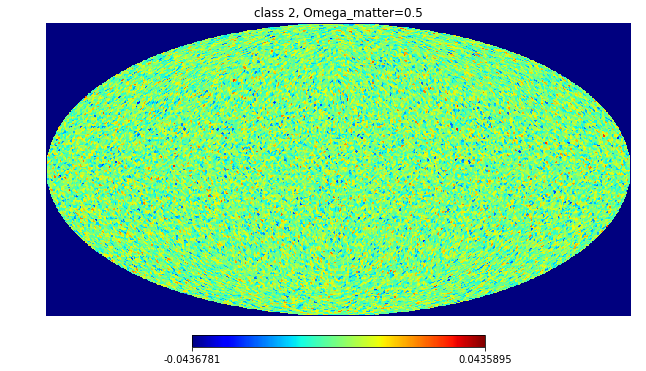

In [4]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
hp.mollview(data['class1'][0], title='class 1, Omega_matter=0.7', nest=True,  cmap='jet', min=cmin ,max=cmax)
hp.mollview(data['class2'][0], title='class 2, Omega_matter=0.5', nest=True,  cmap='jet', min=cmin ,max=cmax)

However, those maps have different power spectral densities.

In [5]:
def psd(x):
    '''Spherical Power Spectral Densities'''
    hatx = hp.map2alm(hp.reorder(x, n2r=True))
    p = hp.alm2cl(hatx)
    return p

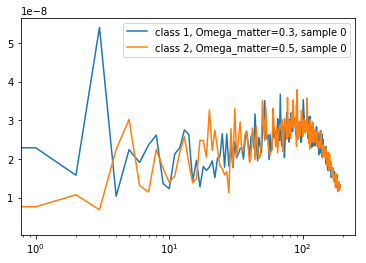

In [6]:
plt.figure()
plt.plot(psd(data['class1'][0]), label='class 1, Omega_matter=0.3, sample 0')
plt.plot(psd(data['class1'][1]), label='class 2, Omega_matter=0.5, sample 0')
plt.xscale('log')
plt.legend()
_ = pl.plot()

When averaging over all the samples, and hence getting closer to the true PSD estimate, the statistical difference becomes obvious.

In [7]:
sample_psd_class1 = []
sample_psd_class2 = []
for i in range(nclass):
    sample_psd_class1.append(psd(data['class1'][i]))
    sample_psd_class2.append(psd(data['class2'][i]))
sample_psd_class1 = np.vstack(sample_psd_class1)
sample_psd_class2 = np.vstack(sample_psd_class2)

psd_class1 = np.mean(sample_psd_class1, axis=0)
psd_class2 = np.mean(sample_psd_class2, axis=0)

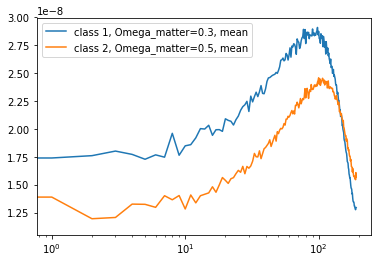

In [8]:
plt.figure()
plt.plot(psd_class1, label='class 1, Omega_matter=0.3, mean')
plt.plot(psd_class2, label='class 2, Omega_matter=0.5, mean')
plt.xscale('log')
plt.legend()
_ = pl.plot()

# Preparing data for the classifier
Let us split the data into training and testing sets. The raw data is stored into `x_raw` and the power spectrum densities into `x_psd`.

In [10]:
from sklearn import preprocessing


# Put all the data in a single matrix
x_raw = np.vstack((data['class1'],data['class2']))
x_raw = x_raw / np.mean(x_raw*x_raw) # Apply some normalization (We do not want to affect the mean)
x_psd = preprocessing.scale(np.vstack((sample_psd_class1,sample_psd_class2)))

# Create the label vector
labels = np.zeros([x_raw.shape[0]])
labels[len(data['class2']):] = 1
labels = labels.astype(np.int)

# Random reordering
p = np.random.permutation(len(labels))
x_raw = x_raw[p,]
x_psd = x_psd[p,]
labels = labels[p]

ntrain = 150
ntest = len(x_raw) - ntrain
x_raw_train = x_raw[:ntrain,]
x_psd_train = x_psd[:ntrain,]
labels_train = labels[:ntrain]
x_raw_test = x_raw[ntrain:,]
x_psd_test = x_psd[ntrain:,]
labels_test = labels[ntrain:]

print('Class 1 VS class 2 \n  Training set: {} / {}\n  Testing set: {} / {}'.format(
    ntrain-sum(labels_train), sum(labels_train), ntest-sum(labels_test), sum(labels_test) ))

Class 1 VS class 2 
  Training set: 78 / 72
  Testing set: 22 / 28


# Classification using SVM
Let us test classify our data using an SVM classifier

An SVM based on the raw feature cannot discriminate the data because the dimensionality of the data is too large. However we observe the PSD features are linearly separable.

In [11]:
from sklearn.svm import SVC

clf_raw = SVC(kernel='rbf')
clf_raw.fit(x_raw_train, labels_train) 

print('Errors on training: {}%'.format(
    sum(np.abs(clf_raw.predict(x_raw_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(clf_raw.predict(x_raw_test)-labels_test))/ntest*100))

Errors on training: 0.0%
Errors on testing: 56.00000000000001%


In [12]:
clf_psd = SVC(kernel='linear')
clf_psd.fit(x_psd_train, labels_train) 

print('Errors on training: {}%'.format(
    sum(np.abs(clf_psd.predict(x_psd_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(clf_psd.predict(x_psd_test)-labels_test))/ntest*100))

Errors on training: 0.0%
Errors on testing: 0.0%


# Classification using a spherical CNN
Let us now classify our data using a spherical convolutional neural network.

In [13]:
from scnn import models

In [14]:
C = 2 # number of class

params = dict()
params['dir_name']       = 'test'
params['num_epochs']     = 5
params['batch_size']     = 10
params['eval_frequency'] = 10

# Building blocks.
params['brelu']          = 'b1relu' # Relu
params['pool']           = 'apool1' # Average pooling

# Architecture.
params['nsides']         = [64, 32, 16] # Sizes of the laplacians are nsides * nisides * 12
params['F']              = [5, 10, 10]  # Number of graph convolutional filters.
params['K']              = [10, 10, 10]  # Polynomial orders.
params['batch_norm']     = [True, True, True]  # Batch norm
params['M']              = [100, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 1e-4
params['dropout']        = 0.8
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['adam']           = True
params['decay_steps']    = ntrain / params['batch_size']

In [18]:
model = models.scnn(**params)

NN architecture
  input: M_0 = 49152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 49152 * 5 / 4 = 61440
    weights: F_0 * F_1 * K_1 = 1 * 5 * 10 = 50
    biases: F_1 = 5
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12288 * 10 / 4 = 30720
    weights: F_1 * F_2 * K_2 = 5 * 10 * 10 = 500
    biases: F_2 = 10
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 3072 * 10 / 1 = 30720
    weights: F_2 * F_3 * K_3 = 10 * 10 * 10 = 1000
    biases: F_3 = 10
  layer 4: fc1
    representation: M_4 = 100
    weights: M_3 * M_4 = 30720 * 100 = 3072000
    biases: M_4 = 100
  layer 5: logits (softmax)
    representation: M_5 = 2
    weights: M_4 * M_5 = 100 * 2 = 200
    biases: M_5 = 2


In [19]:
accuracy, loss, t_step = model.fit(x_raw_train, labels_train, x_raw_test, labels_test)

step 10 / 75 (epoch 0.67 / 5):
  learning_rate = 9.50e-04, loss_average = 2.11e+00
  validation accuracy: 78.00 (39 / 50), f1 (weighted): 77.51, loss: 2.17e+00
  time: 114s (wall 18s)
step 20 / 75 (epoch 1.33 / 5):
  learning_rate = 9.03e-04, loss_average = 1.47e+00
  validation accuracy: 96.00 (48 / 50), f1 (weighted): 96.01, loss: 1.27e+00
  time: 220s (wall 35s)
step 30 / 75 (epoch 2.00 / 5):
  learning_rate = 8.57e-04, loss_average = 1.20e+00
  validation accuracy: 96.00 (48 / 50), f1 (weighted): 96.01, loss: 1.47e+00
  time: 325s (wall 51s)
step 40 / 75 (epoch 2.67 / 5):
  learning_rate = 7.74e-04, loss_average = 1.15e+00
  validation accuracy: 98.00 (49 / 50), f1 (weighted): 98.00, loss: 1.16e+00
  time: 434s (wall 67s)
step 50 / 75 (epoch 3.33 / 5):
  learning_rate = 7.35e-04, loss_average = 1.11e+00
  validation accuracy: 100.00 (50 / 50), f1 (weighted): 100.00, loss: 1.10e+00
  time: 544s (wall 83s)
step 60 / 75 (epoch 4.00 / 5):
  learning_rate = 6.98e-04, loss_average = 1.10

In [20]:
print('Errors on training: {}%'.format(
    sum(np.abs(model.predict(x_raw_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(model.predict(x_raw_test)-labels_test))/ntest*100))

INFO:tensorflow:Restoring parameters from /data/SDSC/codes/scnn/scnn/../checkpoints/test/model-75
Errors on training: 0.0%
INFO:tensorflow:Restoring parameters from /data/SDSC/codes/scnn/scnn/../checkpoints/test/model-75
Errors on testing: 0.0%
